In [10]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
P0 = 100000. # Pressure, Pa
T0 = 279.    # Temperature, K
S0 = -0.1   # Supersaturation, 1-RH

In [12]:
aer =  pm.AerosolSpecies('ammonium sulfate',
                          pm.Lognorm(mu=0.05, sigma=2.0, N=1000.),
                          kappa=0.7, bins=100)

In [26]:
from pyrcel import binned_activation

Vs = np.logspace(-1, np.log10(10,), 11)[::-1] # 0.1 - 5.0 m/s
accom = 0.1

smaxes, act_fracs = [], []
for V in Vs:
    # Initialize the model
    model = pm.ParcelModel([aer,], V, T0, S0, P0, accom=accom, console=False)
    par_out, aer_out = model.run(t_end=2500., dt=1.0, solver='cvode',
                                 output='dataframes', terminate=True)
    print(V, par_out.S.max())

    # Extract the supersaturation/activation details from the model
    # output
    S_max = par_out['S'].max()
    time_at_Smax = par_out['S'].argmax() # What if I subtract -1 from this to take second highest supersaturation???????

    #if time_at_Smax == 90 or time_at_Smax == 840:
    #    continue

    #print(S_max, time_at_Smax)
    #print(aer_out['ammonium sulfate'].keys())
    
    print('*****Here: ', S_max, time_at_Smax, aer_out['ammonium sulfate'])#.loc[time_at_Smax])#.iloc[0])

    # wet_sizes_at_Smax = aer_out['ammonium sulfate'].ix[time_at_Smax].iloc[0]
    wet_sizes_at_Smax = aer_out['ammonium sulfate'].loc[time_at_Smax].iloc[0]
    #print('wet_sizes_at_Smax', wet_sizes_at_Smax)
    
    wet_sizes_at_Smax = np.array(wet_sizes_at_Smax.tolist())

    frac_eq, _, _, _ = binned_activation(S_max, T0, wet_sizes_at_Smax, aer)

    # Save the output
    smaxes.append(S_max)
    act_fracs.append(frac_eq)

[CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
10.0 0.015619036454355724
*****Here:  0.015619036454355724 26                    r000          r001          r002          r003  \
0.000000   3.362212e-09  3.615501e-09  3.887896e-09  4.180697e-09   
1.000000   3.373096e-09  3.628150e-09  3.902554e-09  4.197637e-09   
2.000000   3.384214e-09  3.641088e-09  3.917568e-09  4.215012e-09   
3.000000   3.395575e-09  3.654328e-09  3.932954e-09  4.232843e-09   
4.000000   3.407189e-09  3.667882e-09  3.948729e-09  4.251153e-09   
5.000000   3.419067e-09  3.681765e-09  3.964912e-09  4.269965e-09   
6.000000   3.431220e-09  3.695991e-09  3.981521e-09  4.289304e-09   
7.000000   3.443660e-09  3.710576e-09  3.998578e-09  4.309199e-09   
8.000000   3.456399e-09  3.725537e-09  4.016105e-09  4.329680e-09   
9.000000   3.469450e-09  3.740893e-09  4.034127e-09  4.350779e-09   
10.000000  3.482829e-09  3.756663e-09  4

KeyError: 90

In [19]:
Vs

array([10.        ,  6.30957344,  3.98107171,  2.51188643,  1.58489319,
        1.        ,  0.63095734,  0.39810717,  0.25118864,  0.15848932,
        0.1       ])

In [20]:
smaxes_arg, act_fracs_arg = [], []
smaxes_mbn, act_fracs_mbn = [], []

## change here
Vs_copy = Vs#[:9]

for V in Vs_copy:
    smax_arg, _, afs_arg = pm.arg2000(V, T0, P0, [aer], accom=accom)
    smax_mbn, _, afs_mbn = pm.mbn2014(V, T0, P0, [aer], accom=accom)

    smaxes_arg.append(smax_arg)
    act_fracs_arg.append(afs_arg[0])
    smaxes_mbn.append(smax_mbn)
    act_fracs_mbn.append(afs_mbn[0])

In [21]:
print(len(smaxes), len(smaxes_mbn), len(smaxes_arg))

11 11 11


In [22]:
smaxes

[0.03660728614338011,
 0.011651959895644734,
 0.008769896011034782,
 0.006648022301289961,
 0.0050429680002501195,
 0.0038522446504499126,
 0.0029395709374629053,
 0.002240287250210996,
 0.0017047662522893705,
 0.0012955478383312993,
 0.0009847929666095881]

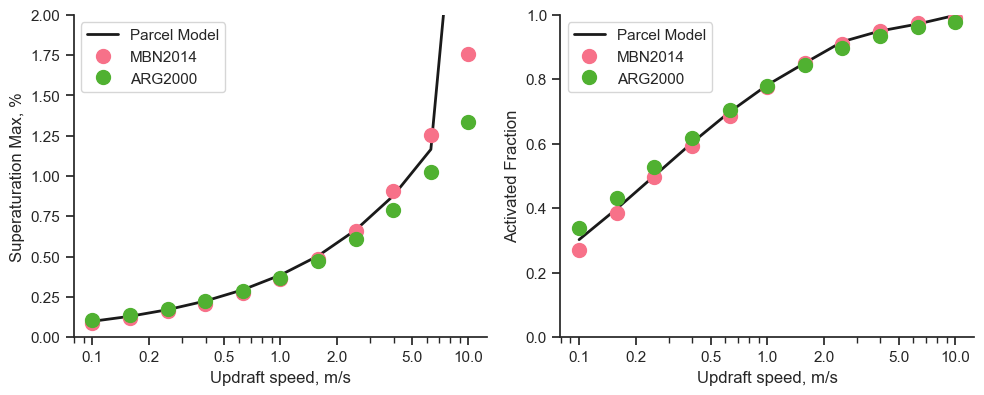

In [23]:
sns.set(context="notebook", style='ticks')
sns.set_palette("husl", 3)
fig, [ax_s, ax_a] = plt.subplots(1, 2, sharex=True, figsize=(10,4))

ax_s.plot(Vs, np.array(smaxes)*100., color='k', lw=2, label="Parcel Model")
ax_s.plot(Vs, np.array(smaxes_mbn)*100., linestyle='None',
          marker="o", ms=10, label="MBN2014" )
ax_s.plot(Vs, np.array(smaxes_arg)*100., linestyle='None',
          marker="o", ms=10, label="ARG2000" )
ax_s.semilogx()
ax_s.set_ylabel("Superaturation Max, %")
ax_s.set_ylim(0, 2.)

ax_a.plot(Vs, act_fracs, color='k', lw=2, label="Parcel Model")
ax_a.plot(Vs, act_fracs_mbn, linestyle='None',
          marker="o", ms=10, label="MBN2014" )
ax_a.plot(Vs, act_fracs_arg, linestyle='None',
          marker="o", ms=10, label="ARG2000" )
ax_a.semilogx()
ax_a.set_ylabel("Activated Fraction")
ax_a.set_ylim(0, 1.)

plt.tight_layout()
sns.despine()

for ax in [ax_s, ax_a]:
    ax.legend(loc='upper left')
    ax.xaxis.set_ticks([0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0])
    ax.xaxis.set_ticklabels([0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0])
    ax.set_xlabel("Updraft speed, m/s")